#### Estimate an AR(1) time series model of the VIX using data from 1990-2015.

An AR(1) model for the daily data can be written as:
$$VIX_t = \alpha + \beta VIX_{t-1} + \epsilon_t$$
where $\epsilon_t$ is white noise.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. Read data
df = pd.read_excel('vixdata.xlsx')
df['dt'] = pd.to_datetime(df['dt'])
df.sort_values('dt', inplace=True)
df.set_index('dt', inplace=True)

# 2. Partition data
train = df.loc[:'2015-12-31'].copy()
test = df.loc['2016-01-01':].copy()

# 3. Prepare training set for AR(1)
#    We'll shift VIX by 1 day to get the lagged variable
train['vix_lag1'] = train['vix'].shift(1)
train.dropna(inplace=True)  # Remove first row which now has NaN

# 4. Fit AR(1)
X = sm.add_constant(train['vix_lag1'])
y = train['vix']
ar1_model = sm.OLS(y, X).fit()

alpha = ar1_model.params['const']
beta = ar1_model.params['vix_lag1']

print(f'alpha: {alpha}, beta: {beta}')

alpha: 0.3718969120091802, beta: 0.9812579145898992


#### For each day in the data, use your model to calculate a 21-trading-day-ahead forecast of the VIX.  What is the R-squared of the realized VIX on your forecast value in sample (over 1990-2015)?  What about out-of-sample (2016-most recent data)?

We will calculate the 21-day ahead forecast using an iterative approach as follows:

1. Start with $\widehat{VIX}_{t+1} = \hat{\alpha} + \hat{\beta} \, VIX_t$.

2. Then $\widehat{VIX}_{t+2} = \hat{\alpha} + \hat{\beta} \, \widehat{VIX}_{t+1}$.

3. Continue until $\widehat{VIX}_{t+21}$.

In [2]:
def ar1_forecast_21(alpha, beta, current_vix):
    """
    Iteratively produce a 21-day-ahead forecast from an AR(1) model.
    """
    vix_pred = current_vix
    for _ in range(21):
        vix_pred = alpha + beta * vix_pred
    return vix_pred

# Create a column in the training set for the 21-day-ahead forecast
train['vix_pred_21'] = np.nan

# We can only forecast if we have 21 more days ahead
for i in range(len(train) - 21):
    current_vix = train['vix'].iloc[i]
    forecast_value = ar1_forecast_21(alpha, beta, current_vix)
    # Store the forecast in the row i+21 (i.e., the date that the forecast is predicting)
    forecast_date_idx = train.index[i + 21]
    train.loc[forecast_date_idx, 'vix_pred_21'] = forecast_value

# Drop rows where we couldn't produce a forecast
train.dropna(subset=['vix_pred_21'], inplace=True)

In [3]:
from sklearn.metrics import r2_score

in_sample_r2 = r2_score(train['vix'], train['vix_pred_21'])
print("In-sample R^2: ", in_sample_r2)


In-sample R^2:  0.6490755537712676


In [4]:
# Similar forecast procedure for test set
test['vix_lag1'] = test['vix'].shift(1)
test.dropna(inplace=True)

test['vix_pred_21'] = np.nan
for i in range(len(test) - 21):
    current_vix = test['vix'].iloc[i]
    forecast_value = ar1_forecast_21(alpha, beta, current_vix)
    forecast_date_idx = test.index[i + 21]
    test.loc[forecast_date_idx, 'vix_pred_21'] = forecast_value

test.dropna(subset=['vix_pred_21'], inplace=True)

out_of_sample_r2 = r2_score(test['vix'], test['vix_pred_21'])
print("Out-of-sample R^2: ", out_of_sample_r2)

Out-of-sample R^2:  0.3652509566327068


#### Plot the out-of-sample realized values (y) against predicted values (x) in a scatterplot.  Include both a 45-degree line and the best-fit line.

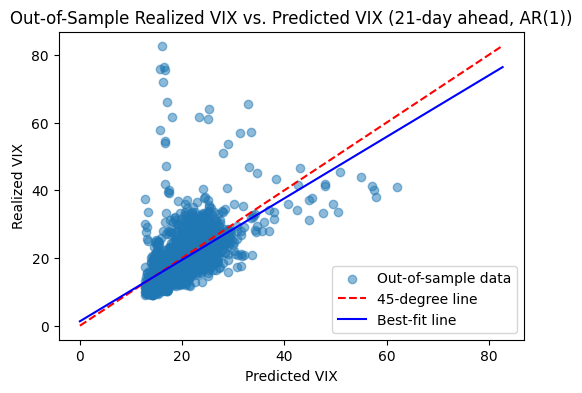

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
realized = test['vix']
predicted = test['vix_pred_21']

# Best-fit line via polyfit
m, b = np.polyfit(predicted, realized, 1)  # slope m, intercept b

plt.figure(figsize=(6,4))
plt.scatter(predicted, realized, alpha=0.5, label="Out-of-sample data")

# 45-degree line
max_val = max(realized.max(), predicted.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='45-degree line')

# Best-fit line
x_vals = np.linspace(0, max_val, 100)
y_vals = m * x_vals + b
plt.plot(x_vals, y_vals, color='blue', label='Best-fit line')

plt.title('Out-of-Sample Realized VIX vs. Predicted VIX (21-day ahead, AR(1))')
plt.xlabel('Predicted VIX')
plt.ylabel('Realized VIX')
plt.legend()
plt.show()


#### Summary of Observations and Potential Improvements

Observations

- Modest Predictive Power. We observed an out of sample $R^2$ of 0.365. An AR(1) model for VIX often has limited predictive power for a 21-day horizon—especially out of sample—because volatility spikes can be abrupt and driven by market events not captured by a simple linear process.
- Mean Reversion. The slope $\beta$ is 0.981. It is less than 1 but very close to it, reflecting that VIX tends to revert toward a long-run average but can stay elevated or depressed for extended periods.
- Out-of-Sample Degradation. The out-of-sample $R^2$ of 0.365 is significantly lower than the in-sample $R^2$ of 0.649. This highlights the difficulty of predicting the VIX with a simple AR(1).


How to Improve the Model

- Use Additional Predictors: Incorporate other macro or market variables (e.g., realized volatility, S&P 500 returns, credit spreads, etc.) that may help explain future volatility.
- Shorter Forecast Horizons: VIX forecasting may be more reliable at shorter horizons (e.g., 1–5 days) rather than 21 days, especially if the market environment is rapidly changing.
- Nonlinear or Regime-Switching Models: VIX dynamics often exhibit regime shifts (calm vs. crisis). A threshold or Markov-switching model might better capture high-vol regimes.
- Use Log Transformation: Transforming the VIX series via logs can sometimes stabilize the variance and improve linear model fit.

Overall, the simple AR(1) is a good baseline to illustrate mean reversion, but it lacks the flexibility to capture large, sudden movements in implied volatility. More sophisticated models—or additional explanatory variables—are often necessary for improved accuracy.